The third edition of *Think Stats* is available now from [Bookshop.org](https://bookshop.org/a/98697/9781098190255) and [Amazon](https://amzn.to/42lmxwu) (those are affiliate links). If you are enjoying the free, online version, consider [buying me a coffee](https://buymeacoffee.com/allendowney).

# Least Squares

This chapter and the next introduce the idea of fitting a model to data.
In this context, a **model** consists of a mathematical description of the relationship between variables -- like a straight line -- and a description of random variation -- like a normal distribution.

When we say that a model fits data, we usually mean that it minimizes errors, which are the distances between the model and the data.
We'll start with one of the most widely-used ways of fitting a model, minimizing the sum of the squared errors, which is called a least squares fit.

We'll also start with models that work with just two variables at a time.
The next chapter introduces models that can handle more than two variables.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap10.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

In [2]:
try:
    import empiricaldist
except ImportError:
    %pip install empiricaldist

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## Least Squares Fit

As a first example, let's return to the scenario from [Chapter 8](section_weighing_penguins).
Suppose you are a researcher in Antarctica, studying local populations of penguins.
As part of your data collection, you capture a sample of penguins, measure and weigh them -- and then release them unharmed.

As you would soon learn, it can be difficult to get penguins to stay on the scale long enough to get an accurate measurement.
Suppose that for some penguins we have measurements like flipper and bill sizes, but no weights.
Let's see if we can use the other measurements to fill in the missing data -- this process is called **imputation**.

We'll start by exploring the relationship between the weights and measurements, using data collected between 2007 and 2010 by researchers at Palmer Station in Antarctica.
The data they collected is freely available -- instructions for downloading it are in the notebook for this chapter.

The following cell downloads the data from a repository created by Allison Horst.

Horst AM, Hill AP, Gorman KB (2020). palmerpenguins: Palmer Archipelago (Antarctica) penguin data. R package version 0.1.0. https://allisonhorst.github.io/palmerpenguins/. doi: 10.5281/zenodo.3960218.

The data was collected as part of the research that led to this paper: Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081

In [4]:
download(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins_raw.csv"
)

We can use `read_csv` to read the data.

In [5]:
penguins = pd.read_csv("penguins_raw.csv").dropna(subset=["Body Mass (g)"])
penguins.shape

(342, 17)

The dataset includes measurements of 151 Adélie penguins.
We can use `query` to select the rows that contain this data.

In [6]:
adelie = penguins.query('Species.str.startswith("Adelie")')
len(adelie)

151

Now suppose we know the flipper length of an Adélie penguin -- let's see how well we can predict its weight.
First we'll select these columns from the `DataFrame`.

In [7]:
xvar = "Flipper Length (mm)"
yvar = "Body Mass (g)"

flipper_length = adelie[xvar]
body_mass = adelie[yvar]

Here's a scatter plot showing the relationship between these quantities.

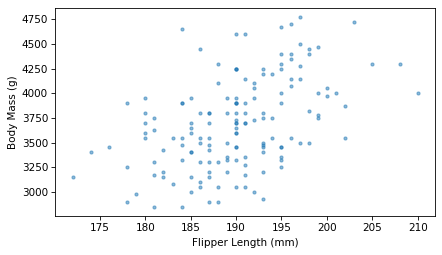

In [8]:
plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)
decorate(xlabel=xvar, ylabel=yvar)

- Flipper Length (지느러미 길이) & 몸무게

It looks like they are related -- we can quantify the strength of the relationship by computing the coefficient of correlation.

In [9]:
np.corrcoef(flipper_length, body_mass)[0, 1]

0.4682016942179395

The correlation is about 0.47, so penguins with longer flippers tend to be heavier.
That's useful because it means we can guess a penguin's weight more accurately if we know its flipper length -- but correlation alone doesn't tell us how to make those guesses.
For that, we need to choose a **line of best fit**.

There are many ways to define the "best" line, but for data like this a common choice is a **linear least squares** fit, which is the straight line that minimizes the mean squared error (MSE).

SciPy provides a function called `linregress` that computes a least squares fit.
The name is short for **linear regression**, which is another term for a model like this.
The arguments of `linregress` are the `x` values and the `y` values, in that order.

In [10]:
from scipy.stats import linregress

result = linregress(flipper_length, body_mass)
result

LinregressResult(slope=32.83168975115011, intercept=-2535.836802200255, rvalue=0.4682016942179395, pvalue=1.3432645947789954e-09, stderr=5.076138407990823, intercept_stderr=964.7984274994062)

The result is a `LinregressResult` object that contains the slope and intercept of the fitted line, along with other information we'll unpack soon.
The slope is about 32.8, which means that each additional millimeter of flipper length is associated with an additional 32.8 grams of body weight.

The intercept is -2535 grams, which might seem nonsensical, since a measured weight can't be negative.
It might make more sense if we use the slope and intercept to evaluate the fitted line at the average flipper length.

In [11]:
x = flipper_length.mean()
y = result.intercept + result.slope * x
x, y

(189.95364238410596, 3700.662251655629)

For a penguin with the average flipper length, about 190 mm, the expected body weight is about 3700 grams.

The following function takes the result from `linregress` and a sequence of `xs` and finds the point on the fitted line for each value of `x`.

In [12]:
def predict(result, xs):
    ys = result.intercept + result.slope * xs
    return ys

The name `predict` might seem odd here -- in natural language, a **prediction** usually pertains to something happening in the future, but in the context of regression, the points on the fitted line are also called predictions.

We can use `predict` to compute the points on the line for a range of flipper sizes.

In [13]:
fit_xs = np.linspace(np.min(flipper_length), np.max(flipper_length))
fit_ys = predict(result, fit_xs)

Here's the fitted line along with the scatter plot of the data.

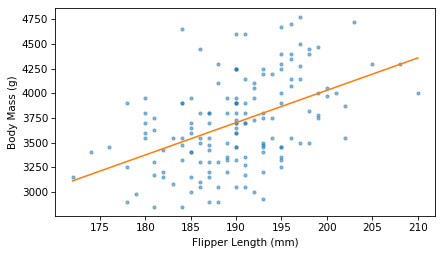

In [14]:
plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)
plt.plot(fit_xs, fit_ys, color="C1")
decorate(xlabel=xvar, ylabel=yvar)

As expected, the fitted line goes through the center of the data and follows the trend.
And some of the predictions are accurate -- but many of the data points are far from the line.
To get a sense of how good (or bad) the predictions are, we can compute the prediction error, which is the vertical distance of each point from the line.
The following function computes these errors, which are also called **residuals**.

In [15]:
def compute_residuals(result, xs, ys):
    fit_ys = predict(result, xs)
    return ys - fit_ys

Here are the residuals for body mass as a function of flipper length.

In [16]:
residuals = compute_residuals(result, flipper_length, body_mass)

As an example, we can look at the results for the first penguin in the dataset.

In [17]:
x = flipper_length[0]
y = predict(result, x)
x, y

(181.0, 3406.699042757915)

The flipper length of the selected penguin is 181 mm and the predicted body mass is 3407 grams.
Now let's see what the actual mass is.

In [18]:
body_mass[0], residuals[0]

(3750.0, 343.30095724208513)

The actual mass of this penguin is 3750 grams, and the residual -- after subtracting away the prediction -- is 343 grams.

The average of the squared residuals is the mean squared error (MSE) of the predictions.

In [19]:
mse = np.mean(residuals**2)
mse

163098.85902884745

By itself, this number doesn't mean very much.
We can make more sense of it by computing the coefficient of determination.

## Coefficient of Determination

Suppose you want to guess the weight of a penguin.
If you know its flipper length, you can use the least squares fit to inform your guess, and the MSE quantifies the accuracy of your guesses, on average.

But what if you don't know the flipper length -- what would you guess?
It turns out that guessing the mean is the best strategy in the sense that it minimizes the MSE.
If we always guess the mean, the prediction errors are the deviations from the mean.

결정계수, R^2

In [20]:
deviations = body_mass - np.mean(body_mass)

And the MSE is the mean squared deviation.

In [21]:
np.mean(deviations**2)

208890.28989956583

You might remember that the mean squared deviation is the variance.

In [22]:
np.var(body_mass)

208890.28989956583

So we can think of the variance of the masses as the MSE if we always guess the mean, and the variance of the residuals as the MSE if we use the regression line.
If we compute the ratio of these variances and subtract it from 1, the result indicates how much the MSE is reduced if we use flipper lengths to inform our guesses.

The following function computes this value, which is technically called the **coefficient of determination**, but because it is denoted $R^2$, most people call it "R squared".

In [23]:
def coefficient_of_determination(ys, residuals):
    return 1 - np.var(residuals) / np.var(ys)

In the example, $R^2$ is about 0.22, which means that the fitted line reduces MSE by 22%.

In [24]:
R2 = coefficient_of_determination(body_mass, residuals)
R2

0.21921282646854878

It turns out that there's a relationship between the coefficient of determination, $R^2$, and the coefficient of correlation, $r$.
As you might guess based on the notation, $r^2 = R^2$.

We can show that's true by computing the square root of $R^2$.

In [25]:
r = np.sqrt(R2)
r

0.46820169421793933

And comparing it to the correlation we computed earlier.

In [26]:
corr = np.corrcoef(flipper_length, body_mass)[0, 1]
corr

0.4682016942179395

They are the same except for a small difference due to floating-point approximation.

The `linregress` function also computes this value and returns it as an attribute in the `RegressionResult` object.

In [27]:
result.rvalue

0.4682016942179395

The coefficients of determination and correlation convey mostly the same information, but they are interpreted differently:

* Correlation quantifies the strength of the relationship on a scale from -1 to 1.

* $R^2$ quantifies the ability of the fitted line to reduce MSE.

Also, $R^2$ is always positive, so it doesn't indicate whether the correlation is positive or negative.

## Minimizing MSE

Earlier I said that the least squares fit is the straight line that minimizes the mean squared error (MSE).
We won't prove that, but we can test it by adding small random values to the intercept and slope, and checking whether the MSE gets worse.

In [28]:
intercept = result.intercept + np.random.normal(0, 1)
slope = result.slope + np.random.normal(0, 1)

To run the test, we need to make an object with `intercept` and `slope` attributes -- we'll use the `SimpleNamespace` object provided by the `types` module.

In [29]:
from types import SimpleNamespace

fake_result = SimpleNamespace(intercept=intercept, slope=slope)
fake_result

namespace(intercept=-2535.7059791276633, slope=32.77780993832985)

We can pass this object to `compute_residuals` and use the residuals to compute the MSE.

In [30]:
fake_residuals = compute_residuals(fake_result, flipper_length, body_mass)
fake_mse = np.mean(fake_residuals**2)

If we compare the result to the MSE of the least squares line, it is always worse.

In [31]:
mse, fake_mse, fake_mse > mse

(163098.85902884745, 163201.07000946993, True)

Minimizing MSE is nice, but it's not the only definition of "best".
One alternative is to minimize the absolute values of the errors.
Another is to minimize the shortest distance from each point to the fitted line, which is called the "total error".
In some contexts, guessing too high might be better (or worse) than guessing too low.
In that case you might want to compute a cost function for each residual, and minimize total cost.

But the least squares fit is much more widely used than these alternatives, primarily because it is efficient to compute.
The following function shows how.

In [32]:
def least_squares(xs, ys):
    xbar = np.mean(xs)
    ybar = np.mean(ys)

    xdev = xs - xbar
    ydev = ys - ybar

    slope = np.sum(xdev * ydev) / np.sum(xdev**2)
    intercept = ybar - slope * xbar

    return intercept, slope

To test this function, we'll use flipper length and body mass again.

In [33]:
intercept, slope = least_squares(flipper_length, body_mass)
intercept, slope

(-2535.8368022002524, 32.831689751150094)

And we can confirm that we get the same results we got from `linregress`.

In [34]:
np.allclose([intercept, slope], [result.intercept, result.slope])

True

Minimizing MSE made sense when computational efficiency was more important than choosing the method most appropriate to the problem at hand.
But that's no longer the case, so it is worth considering whether squared residuals are the right thing to minimize.

## Estimation

The parameters `slope` and `intercept` are estimates based on a sample.
Like other estimates, they are vulnerable to non-representative sampling, measurement error, and variability due to random sampling.
As usual, it's hard to quantify the effect of non-representative sampling and measurement error.
It's easier to quantify the effect of random sampling.

One way to do that is a kind of resampling called **bootstrapping**: we'll treat the sample as if it were the whole population and draw new samples, with replacement, from the observed data.
The following function takes a `DataFrame` and uses the `sample` method to resample the rows and return a new `DataFrame`.

In [35]:
def resample(df):
    n = len(df)
    return df.sample(n, replace=True)

And the following function takes a `DataFrame`, finds the least squares fit, and returns the slope of the fitted line.

In [36]:
def estimate_slope(df):
    xs, ys = df["Flipper Length (mm)"], df["Body Mass (g)"]
    result = linregress(xs, ys)
    return result.slope

We can use these functions to generate many simulated datasets and compute the slope for each one.

In [37]:
# Seed the random number generator so we get the same results every time

np.random.seed(1)

In [38]:
resampled_slopes = [estimate_slope(resample(adelie)) for i in range(1001)]

The result is a sample from the sampling distribution of the slope.
Here's what it looks like.

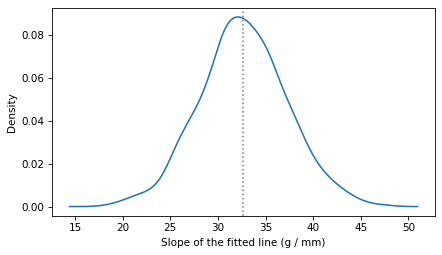

In [39]:
from thinkstats import plot_kde

plot_kde(resampled_slopes)
decorate(xlabel="Slope of the fitted line (g / mm)", ylabel="Density")

We can use `percentile` to compute a 90% confidence interval.

In [40]:
ci90 = np.percentile(resampled_slopes, [5, 95])
print(result.slope, ci90)

32.83168975115011 [25.39604591 40.21054526]


So we could report that the estimated slope is 33 grams / mm with a 90% CI [25, 40] grams / mm.

The standard error of the estimate is the standard deviation of the sampling distribution.

In [41]:
stderr = np.std(resampled_slopes)
stderr

4.570238986584834

The `RegressionResult` object we got from `linregress` provides an approximation of the standard error, based on some assumptions about the shape of the distribution.

In [42]:
result.stderr

5.076138407990823

The standard error we computed by resampling is a little smaller, but the difference probably doesn't matter in practice.

## Visualizing Uncertainty

Each time we resample the dataset, we get a different fitted line.
To see how much variation there is in the lines, one option is to loop through them and plot them all.
The following function takes a resampled `DataFrame`, computes a least squares fit, and generates predicted values for a sequence of `xs`.

| 구분 | 리샘플링 (Resampling) | 부트스트래핑 (Bootstrapping) |
| :--- | :--- | :--- |
| **개념** | 데이터를 반복적으로 재추출하는 모든 방법 (**상위 개념**) | 리샘플링의 한 종류 (**하위 개념**) |
| **핵심 특징** | 목적에 따라 다양한 추출 방법 사용 | 반드시 '복원 추출'을 사용 |
| **주요 목적** | 모델 검증, 가설 검정, 불확실성 추정 등 다양 | 주로 통계치의 **불확실성 추정** (신뢰구간, 표준오차) |

In [44]:
def fit_line(df, fit_xs):
    xs, ys = df["Flipper Length (mm)"], df["Body Mass (g)"]
    result = linregress(xs, ys)
    fit_ys = predict(result, fit_xs)
    return fit_ys

Here's the sequence of `xs` we'll use.

In [45]:
xs = adelie["Flipper Length (mm)"]
fit_xs = np.linspace(np.min(xs), np.max(xs))

And here's what the fitted lines look like, along with a scatter plot of the data.

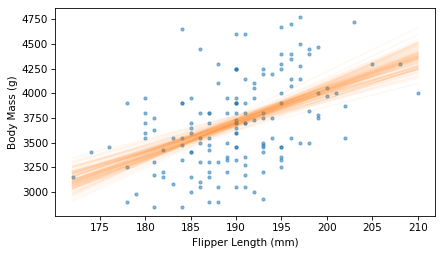

In [46]:
plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)

for i in range(101):
    fit_ys = fit_line(resample(adelie), fit_xs)
    plt.plot(fit_xs, fit_ys, color="C1", alpha=0.05)

decorate(xlabel=xvar, ylabel=yvar)

Near the middle, the fitted lines are close together -- at the extremes, they are farther apart.

Another way to represent the variability of the fitted lines is to plot a 90% confidence interval for each predicted value.
We can do that by collecting the fitted lines as a list of arrays.

In [47]:
fitted_ys = [fit_line(resample(adelie), fit_xs) for i in range(1001)]

We can think of this list of arrays as a two-dimensional array with one row for each fitted line and one column corresponding to each of the `xs`.

We can use `percentile` with the `axis=0` argument to find the 5th, 50th, and 95th percentiles of the `ys` corresponding to each of the `xs`.

In [48]:
low, median, high = np.percentile(fitted_ys, [5, 50, 95], axis=0)

Now we'll use `fill_between` to plot a region between the 5th and 95 percentiles, which represents the 90% CI, along with the median value in each column and a scatter plot of the data.

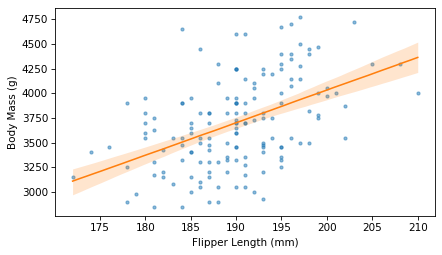

In [49]:
plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)

plt.fill_between(fit_xs, low, high, color="C1", lw=0, alpha=0.2)
plt.plot(fit_xs, median, color="C1")

decorate(xlabel=xvar, ylabel=yvar)

This is my favorite way to represent the variability of a fitted line due to random sampling.

## Transformation

Before fitting a line to data, it is sometimes useful to transform one or both variables, for example by computing the squares of the values, their square roots, or their logarithms.
To demonstrate, we'll use heights and weights from the Behavioral Risk Factor Surveillance System (BRFSS), described in [Chapter 5](section_lognormal_distribution).

The following cell downloads the BRFSS data.

In [50]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

We can load the BRFSS data like this.

In [51]:
from thinkstats import read_brfss

brfss = read_brfss()

Next we'll find the rows with valid data and select the columns containing heights and weights.

In [52]:
valid = brfss.dropna(subset=["htm3", "wtkg2"])
heights, weights = valid["htm3"], valid["wtkg2"]

We can use `linregress` to compute the slope and intercept of the least squares fit.

In [53]:
result_brfss = linregress(heights, weights)
result_brfss.intercept, result_brfss.slope

(-82.65926054409888, 0.9570745850332266)

The slope is about 0.96, which means that an increase of 1 centimeter corresponds to an increase of almost 1 kilogram, on average.
We can use `predict` again to generate predicted values for a range of `xs`.

In [54]:
fit_xs = np.linspace(heights.min(), heights.max())
fit_ys = predict(result_brfss, fit_xs)

Before we make a scatter plot of the data, it's useful to jitter the heights and weights.

In [55]:
from thinkstats import jitter

jittered_heights = jitter(heights, 2)
jittered_weights = jitter(weights, 1.5)

And we'll use the mean and standard deviation of the heights to choose the limits of the $x$ axis.

In [56]:
m, s = heights.mean(), heights.std()
xlim = m - 4 * s, m + 4 * s
ylim = 0, 200

Here's a scatter plot of the jittered data along with the fitted line.

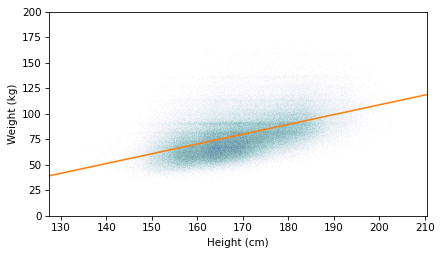

In [57]:
plt.scatter(jittered_heights, jittered_weights, alpha=0.01, s=0.1)
plt.plot(fit_xs, fit_ys, color="C1")
decorate(xlabel="Height (cm)", ylabel="Weight (kg)", xlim=xlim, ylim=ylim)

The fitted line doesn't pass through the densest part of the scatter plot.
That's because the weights don't follow a normal distribution.
As we saw in [Chapter 5](section_lognormal_distribution), adult weights tend to follow a lognormal distribution, which is skewed toward larger values -- and those values pull the fitted line up.

Another cause for concern is the distribution of the residuals, which looks like this.

In [58]:
residuals = compute_residuals(result_brfss, heights, weights)

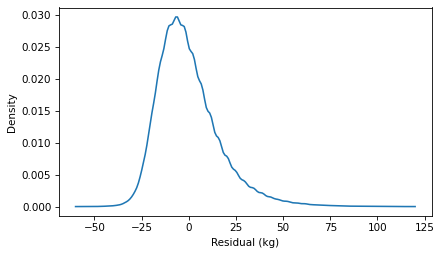

In [59]:
from thinkstats import make_pmf

pmf_kde = make_pmf(residuals, -60, 120)
pmf_kde.plot()

decorate(xlabel="Residual (kg)", ylabel="Density")

- 무게가 많이 나가는 과체중 데이터에 대한 예측력이 떨어진다는 것을 짐작할 수 있음

The distribution of the residuals is skewed to the right.
By itself, that's not necessarily a problem, but it suggests that the least squares fit has not characterized the relationship between these variables properly.

If the weights follow a lognormal distribution, their logarithms follow a normal distribution.
So let's see what happens if we fit a line to the logarithms of weight as a function of height.

In [60]:
log_weights = np.log10(weights)
result_brfss2 = linregress(heights, log_weights)
result_brfss2.intercept, result_brfss2.slope

(0.9930804163932888, 0.00528145416941777)

- 그래서 로그변환!

Because we transformed one of the variables, the slope and intercept are harder to interpret.
But we can use `predict` to compute the fitted line.

In [61]:
fit_xs = np.linspace(heights.min(), heights.max())
fit_ys = predict(result_brfss2, fit_xs)

And then plot it along with a scatter plot of the transformed data.

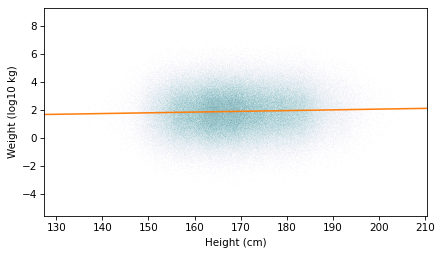

In [62]:
jittered_log_weights = jitter(log_weights, 1.5)
plt.scatter(jittered_heights, jittered_log_weights, alpha=0.01, s=0.1)
plt.plot(fit_xs, fit_ys, color="C1")
decorate(xlabel="Height (cm)", ylabel="Weight (log10 kg)", xlim=xlim)

The fitted line passes through the densest part of the plot, and the actual values extend about the same distance above and below the line -- so the distribution of the residuals is roughly symmetric.

In [63]:
residuals = compute_residuals(result_brfss2, heights, log_weights)

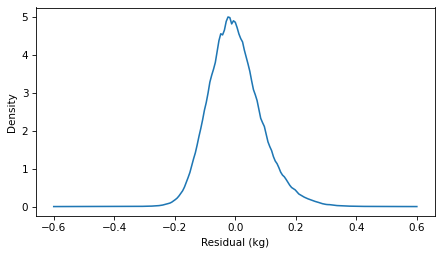

In [64]:
pmf_kde = make_pmf(residuals, -0.6, 0.6)
pmf_kde.plot()

decorate(xlabel="Residual (kg)", ylabel="Density")

The appearance of the scatter plot and the distribution of the residuals suggest that the relationship of height and log-transformed weight is well described by the fitted line.
If we compare the $r$ values of the two regressions, we see that the correlation of height with log-transformed weights is slightly higher.

In [65]:
result_brfss.rvalue, result_brfss2.rvalue

(0.508736478973458, 0.5317282605983428)

Which means that the $R^2$ value is slightly higher, too.

In [66]:
result_brfss.rvalue**2, result_brfss2.rvalue**2

(0.25881280503831167, 0.2827349431189391)

If we use heights to guess weights, the guesses are a little better if we work with the log-transformed weights.

However, transforming the data makes the parameters of the model harder to interpret -- it can help to invert the transformation before presenting the results.
For example, the inverse of a logarithm in base 10 is exponentiation with base 10.
Here's what the fitted line looks like after the inverse transformation, along with the untransformed data.

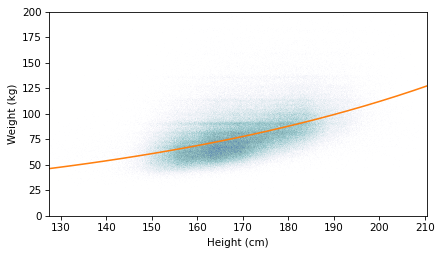

In [67]:
plt.scatter(jittered_heights, jittered_weights, alpha=0.01, s=0.1)
plt.plot(fit_xs, 10**fit_ys, color="C1")
decorate(xlabel="Height (cm)", ylabel="Weight (kg)", xlim=xlim, ylim=ylim)

A fitted line that's straight with respect to the transformed data is curved with respect to the original data.

## Glossary

-   **model**: In the context of regression, a model is a mathematical description of the relationship between variables -- such as a straight line -- along with a description of random variation -- such as a normal distribution.

-   **imputation:** A process for estimating and filling in missing values in a dataset.

-   **line of best fit:** A line (or curve) that best describes a relationship between variables, by some definition of "best".

-   **linear regression:** A method for finding a line of best fit.

-   **prediction**: A point on a line of best fit -- in the context of regression, it is not necessarily a claim about the future.

-   **residual**: The difference between an observed value and a value predicted by a line of best fit.

-   **linear least squares fit:** A line that minimizes the sum of squared residuals.

-   **coefficient of determination**: A statistic, denoted $R^2$ and often pronounced "R squared", that quantifies how well a model fits the data.

-   **bootstrap resampling**: A way of resampling by treating the sample as a population and drawing new samples with the same size as the original, with replacement.

## Exercises

### Exercise 10.1

In this chapter we computed a least squares fit for penguin weights as a function of flipper length.
There are two other measurements in the dataset we can also consider: culmen length and culmen depth (the culmen is the top ridge of the bill).

Compute the least squares fit for weight as a function of culmen length.
Make a scatter plot of these variables and plot the fitted line.

Based on the `rvalue` attribute of the `RegressionResult` object, what is the correlation of these variables?
What is the coefficient of determination?
Which is a better predictor of weight, culmen length or flipper length?

In [68]:
xvar = "Culmen Length (mm)"
yvar = "Body Mass (g)"

culmen_length = adelie[xvar]
body_mass = adelie[yvar]

In [69]:
# Solution goes here
import numpy as np
from scipy.stats import linregress

result_culmen = linregress(culmen_length, body_mass)
print(result_culmen)

LinregressResult(slope=94.49981540132973, intercept=34.882988653715984, rvalue=0.5488658064533206, pvalue=2.9547579193016823e-13, stderr=11.790478185101207, intercept_stderr=458.43870972286146)


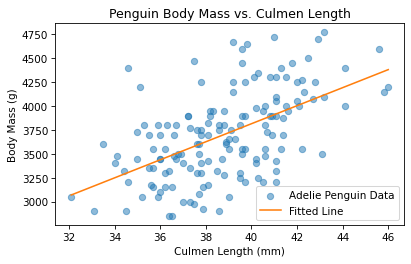

In [72]:
# Solution goes here
import matplotlib.pyplot as plt

fit_xs = np.linspace(culmen_length.min(), culmen_length.max())
fit_ys = result_culmen.intercept + result_culmen.slope * fit_xs

plt.scatter(culmen_length, body_mass, alpha=0.5, label='Adelie Penguin Data')
plt.plot(fit_xs, fit_ys, color='C1', label='Fitted Line')
plt.xlabel("Culmen Length (mm)")
plt.ylabel("Body Mass (g)")
plt.title("Penguin Body Mass vs. Culmen Length")
plt.legend()
plt.show()

In [71]:
# Solution goes here
# 상관계수
correlation = result_culmen.rvalue
print(f"상관계수 (r): {correlation:.4f}")

# 결정계수
R2 = correlation**2
print(f"결정계수 (R²): {R2:.4f}")

상관계수 (r): 0.5489
결정계수 (R²): 0.3013


### Exercise 10.2

In this chapter we used resampling to approximate the sampling distribution for the slope of a fitted line.
We can approximate the sampling distribution of the intercept the same way:

1. Write a function called `estimate_intercept` that takes a resampled `DataFrame` as an argument, computes the least squares fit of penguin weight as a function of flipper length, and returns the intercept.

2. Call the function with many resampled versions of `adelie` and collect the intercepts.

3. Use `plot_kde` to plot the sampling distribution of the intercept.

4. Compute the standard error and a 90% confidence interval.

5. Check that the standard error you get from resampling is consistent with the `intercept_stderr` attribute in the `RegressionResult` object -- it might be a little smaller.

In [ ]:
# Solution goes here
from scipy.stats import linregress

# y절편 (intercept)
def estimate_intercept(df):
    xs = df["Flipper Length (mm)"]
    ys = df["Body Mass (g)"]
    result = linregress(xs, ys)
    return result.intercept

In [74]:
# Solution goes here
def resample(df):
    n = len(df)
    return df.sample(n, replace=True)

resampled_intercepts = [estimate_intercept(resample(adelie)) for i in range(1001)]

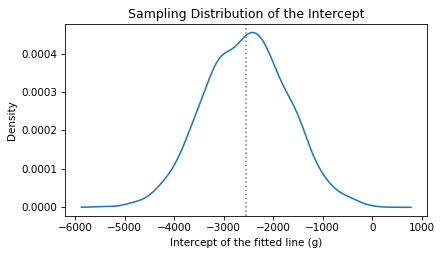

In [75]:
# Solution goes here
from thinkstats import plot_kde, decorate
import matplotlib.pyplot as plt

# KDE
plot_kde(resampled_intercepts)

decorate(xlabel="Intercept of the fitted line (g)", 
         ylabel="Density",
         title="Sampling Distribution of the Intercept")
plt.show()

In [76]:
# Solution goes here
# 표준 오차 계산
stderr = np.std(resampled_intercepts)
print(f"Standard Error (from resampling): {stderr:.2f}")

# 90% 신뢰 구간
ci90 = np.percentile(resampled_intercepts, [5, 95])
print(f"90% Confidence Interval: {ci90[0]:.2f}, {ci90[1]:.2f}")

Standard Error (from resampling): 832.20
90% Confidence Interval: -3894.66, -1187.14


In [ ]:
# Solution goes here
# 원본 데이터
flipper_length = adelie["Flipper Length (mm)"]
body_mass = adelie["Body Mass (g)"]
original_result = linregress(flipper_length, body_mass)

intercept_stderr_from_scipy = original_result.intercept_stderr
print(f"Intercept stderr (from SciPy): {intercept_stderr_from_scipy:.2f}")

print(f"Standard Error (from resampling): {stderr:.2f}")

Intercept stderr (from SciPy): 964.80
Standard Error (from resampling): 832.20


### Exercise 10.3

A person's Body Mass Index (BMI) is their weight in kilograms divided by their height in meters raised to the second power.
In the BRFSS dataset, we can compute BMI like this, after converting heights from centimeters to meters.

In [78]:
heights_m = heights / 100
bmis = weights / heights_m**2

In this definition, heights are squared, rather than raised to some other exponent, because of the observation -- early in the history of statistics -- that average weight increases roughly in proportion to height squared.

To see whether that's true, we can use data from the BRFSS, a least squares fit, and a little bit of math.
Suppose weight is proportional to height raised to an unknown exponent, $a$.
In that case, we can write:

$$w = b h^a$$

where $w$ is weight, $h$ is height, and $b$ is an unknown constant of proportionality.
Taking logarithms of both sides:

$$\log w = \log b + a \log h$$

So, if we compute a least squares fit for log-transformed weights as a function of log-transformed heights, the slope of the fitted line estimates the unknown exponent $a$.

Compute the logarithms of height and weight.
You can use any base for the logarithms, as long as it's the same for both transformations.
Compute a least squares fit.
Is the slope close to 2?

In [79]:
# Solution goes here
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

log_heights = np.log10(heights)
log_weights = np.log10(weights)

result_loglog = linregress(log_heights, log_weights)

slope = result_loglog.slope
print(f"계산된 기울기 (지수 a의 추정치): {slope:.4f}")

계산된 기울기 (지수 a의 추정치): 2.0409


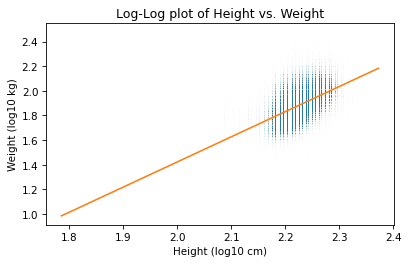

In [80]:
# Solution goes here
fit_xs = np.linspace(log_heights.min(), log_heights.max())
fit_ys = result_loglog.intercept + result_loglog.slope * fit_xs

plt.scatter(log_heights, log_weights, alpha=0.01, s=0.1)
plt.plot(fit_xs, fit_ys, color='C1')
plt.xlabel("Height (log10 cm)")
plt.ylabel("Weight (log10 kg)")
plt.title("Log-Log plot of Height vs. Weight")
plt.show()

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)